In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [21]:
df = pd.read_csv('churn_data.csv')
df.head(50)

,uuid,date,event
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact
5,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,big_purchase
6,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-05-16,small_purchase
7,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-06-05,contact
8,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-06-14,contact
9,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-07-11,contact


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104103 entries, 0 to 104102
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   uuid    104103 non-null  object
 1   date    104103 non-null  object
 2   event   104103 non-null  object
dtypes: object(3)
memory usage: 2.4+ MB


In [20]:
print("Number of Events: ",df.shape[0])
print("Number of Unique Users: ",df.uuid.nunique())
print("Type of Events: ", df.event.unique()[0:3].tolist())

Number of Events:  104103
Number of Unique Users:  1034
Type of Events:  ['small_purchase', 'contact', 'big_purchase']


In [25]:
df['day'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.day
df['dayW'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.day_name()
df['month'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.month
df['year'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.year
df['monthYear'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.to_period('M')


In [26]:
df.head(20)

,uuid,date,event,day,dayW,month,year,monthYear
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase,7,Thursday,2,2019,2019-02
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase,20,Wednesday,2,2019,2019-02
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact,12,Friday,4,2019,2019-04
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact,19,Friday,4,2019,2019-04
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact,30,Tuesday,4,2019,2019-04
5,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,big_purchase,30,Tuesday,4,2019,2019-04
6,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-05-16,small_purchase,16,Thursday,5,2019,2019-05
7,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-06-05,contact,5,Wednesday,6,2019,2019-06
8,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-06-14,contact,14,Friday,6,2019,2019-06
9,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-07-11,contact,11,Thursday,7,2019,2019-07


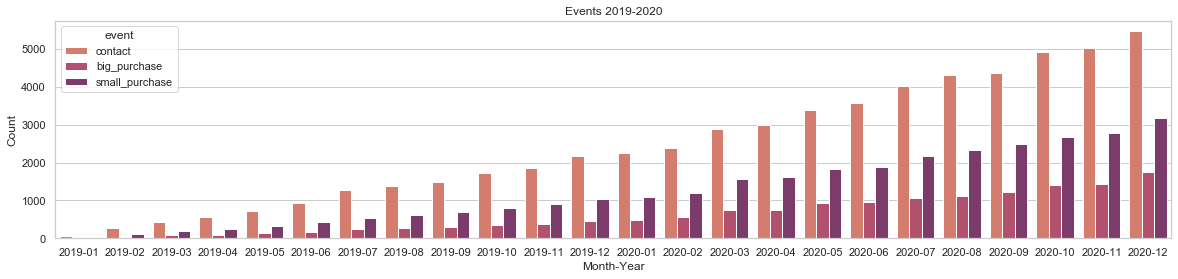

In [34]:
plt.figure(figsize=(20,4))
ax = sns.countplot(data=df.sort_values(by='monthYear',ascending=True),x="monthYear", hue="event",palette="flare")
sns.set(style="whitegrid")
plt.xlabel('Month-Year')
plt.ylabel('Count')
plt.title('Events 2019-2020')
plt.show()